# <center> Projet :  Moteur de classiffication </center>



<img src="https://www.affacturage.fr/img/produits/place-de-marche-marketplace.jpg" width=492>


### <center>Thème : Marketplace </center>
### <center>https://openclassrooms.com/fr/paths/164/projects/631/assignment<center>

# Objectif du notebook

L'objet de ce projet est de proposer une étude de faisabilité d'un moteur de classification d'articles  basé sur une image et une 

Bonjour, 

Merci pour ton aide sur ce projet !

Ta mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles, basé sur une image et une description, pour l'automatisation de l'attribution de la catégorie de l'article.

Tu dois analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de dimension, puis un clustering. Les résultats de la réduction de dimension et du clustering seront à présenter sous la forme de graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories réelles et les clusters. Ces résultats illustreront le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

Pourrais-tu nous démontrer, par cette approche de modélisation, la faisabilité de regrouper automatiquement des produits de même catégorie ?

Voici les contraintes : 

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
- deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder). 
 

En pièce jointe, tu trouveras un exemple de mise en œuvre de ces approches sur un autre dataset. Je t’invite à l’utiliser comme point de départ, cela va te faire gagner beaucoup de temps !

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.

Merci encore, 

Linda

P.S. : j’insiste sur le fait qu’on n’a pas besoin d’un moteur de classification supervisée à ce stade, mais bien d’une étude de faisabilité !

In [1]:
#Data management/data viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


#Statistiques/ML
import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score # score recall
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn import cluster, metrics

from sklearn.metrics import (
    adjusted_rand_score as ari
)
from scipy.cluster.hierarchy import fcluster, linkage
import scipy

#Image
from PIL import Image
from IPython.display import  display
from PIL import ImageFilter
import cv2 
from matplotlib.image import imread

#Texte
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.manifold._t_sne import TSNE

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

#Autre
import time
import os
#Afficher toute les colonnes
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import time, cv2


# Data Management

Chargeons le jeu de données;

In [2]:
try :
    df=pd.read_csv("E_commerce.csv")
    os.chdir(os.getcwd()+"/Images")
except :
    df.head()

In [3]:
print(df.shape)

(1050, 15)


On a 1050 biens de consommations regrouppés en 15 caractéristiques.

In [4]:
df.product_category_tree.value_counts()

["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                                                                                               56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                                                                                                 26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                                                                                        23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                                                                                               22
["Home Furnishing >> Bath Linen >> Towels"]                                                                                                                 19
                                                                                                                                                            ..
["Beauty and Personal Care >> Body and Skin Ca

Les catégories sont trop diversifiées et notre jeu de données est petit. Nous allons allégé les catégories.

In [5]:
categorie =df.product_category_tree[0].split(" >>")[0]
categorie =categorie.replace("[", "")
categorie =categorie.replace("''", "")
categorie=categorie.replace("\"", "")
categorie

'Home Furnishing'

In [6]:
def target(categorie):
    """Creation catégorie des articles"""
    categorie =categorie.split(" >>")[0]
    categorie =categorie.replace("[", "")
    categorie =categorie.replace("''", "")
    categorie=categorie.replace("\"", "")
    return(categorie)
    
target(df.product_category_tree[0])    
target(df.product_category_tree[30])    

'Watches'

In [7]:
df["categorie_article"]=0

df["categorie_article"]=df["product_category_tree"].apply(lambda x: target(x))
df["categorie_article"].value_counts()

Beauty and Personal Care      150
Computers                     150
Home Furnishing               150
Home Decor & Festive Needs    150
Watches                       150
Kitchen & Dining              150
Baby Care                     150
Name: categorie_article, dtype: int64

On a 7 catégories d'articles avec 150 échantillons chacun.

Les données images sont récupérables à partir de la colonne image.

In [8]:
df["image"][1]

'7b72c92c2f6c40268628ec5f14c6d590.jpg'

Les données textes sont dans la colonne description. Ils correspondent à la description du produit.

In [9]:
df["product_url"][1]

'http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH'

In [10]:
df["description"][1]

'Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel'

# Partie Image

Dans cette partie, nous étudierons la faisabilité d'un moteur de classiffication en utilisant uniquement les images des articles de notre échantillon.

### Pré-processing

Manipulation des images et créations d'un dataset.

In [11]:
df_image=df[["categorie_article","image"]]
df_image["image_propre"]=df.index
df_image["image_propre"]=df_image["image_propre"].apply(lambda x: str(x)+".jpg")
df_image.head()

<ipython-input-11-aed7f68bde15>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_image["image_propre"]=df.index
<ipython-input-11-aed7f68bde15>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_image["image_propre"]=df_image["image_propre"].apply(lambda x: str(x)+".jpg")


categorie_article                                 image image_propre
0   Home Furnishing  55b85ea15a1536d46b7190ad6fff8ce7.jpg        0.jpg
1         Baby Care  7b72c92c2f6c40268628ec5f14c6d590.jpg        1.jpg
2         Baby Care  64d5d4a258243731dc7bbb1eef49ad74.jpg        2.jpg
3   Home Furnishing  d4684dcdc759dd9cdf41504698d737d8.jpg        3.jpg
4   Home Furnishing  6325b6870c54cd47be6ebfbffa620ec7.jpg        4.jpg

In [12]:
exemple_Watch=[index for index, value in enumerate(list(df_image["categorie_article"]=="Watches")) if value == 1][:3]
exemple_Baby=[index for index, value in enumerate(list(df_image["categorie_article"]=="Baby Care")) if value == 1][:3]
exemple_Computer=[index for index, value in enumerate(list(df_image["categorie_article"]=="Computers")) if value == 1][:3]

Baby Care


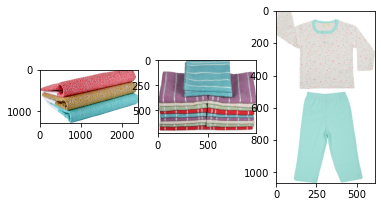

Computer


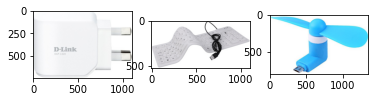

Watches


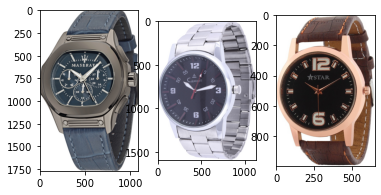

In [13]:
print("Baby Care")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Baby[i],"image"]))
plt.show()
print("Computer")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Computer[i],"image"]))
plt.show()
print("Watches")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Watch[i],"image"]))
plt.show()


In [14]:
for i in range(len(df_image.image)):
    image = cv2.imread(df_image.image[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    nom=str(i)
    cv2.imwrite(str(nom)+".jpg", image) 

Baby Care


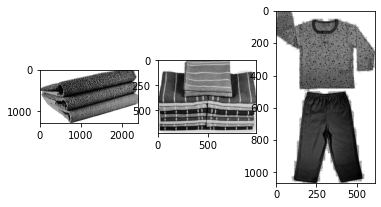

Computer


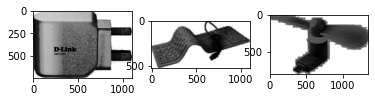

Watches


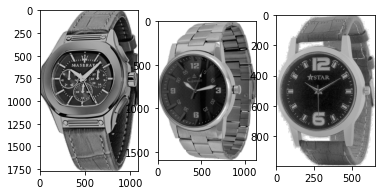

In [15]:
print("Baby Care")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Baby[i],"image_propre"]),cmap='gray')
plt.show()
print("Computer")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Computer[i],"image_propre"]),cmap='gray')
plt.show()
print("Watches")
for i in range(3):
    plt.subplot(130 + 1 + i)
    plt.imshow(imread(df_image.loc[exemple_Watch[i],"image_propre"]),cmap='gray')
plt.show()

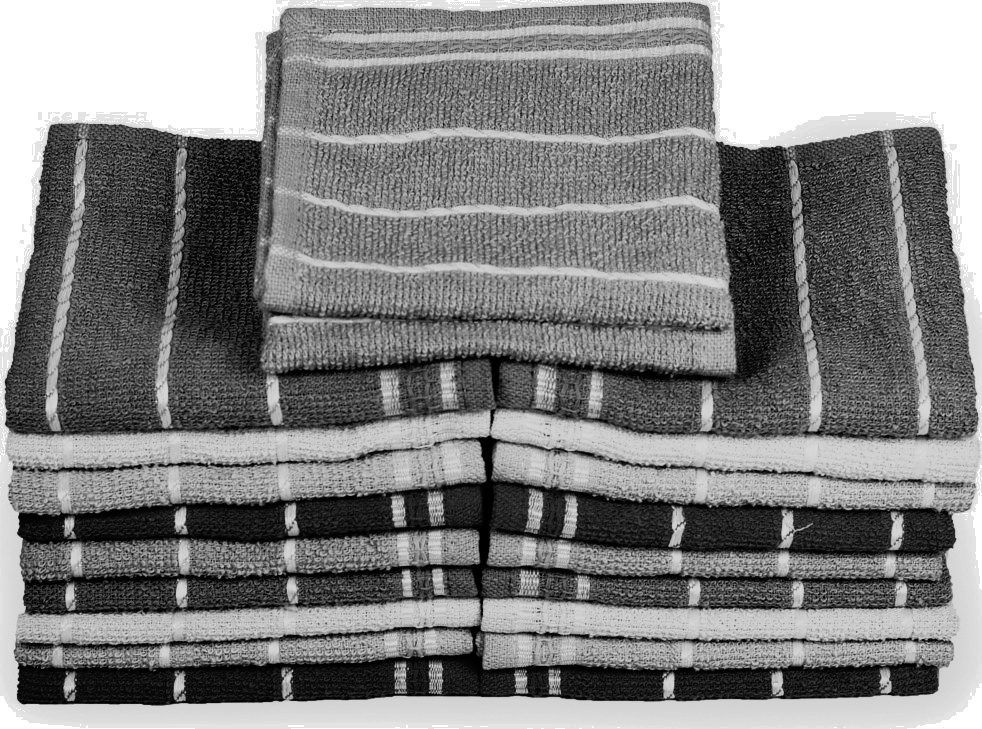

Taille de la matrice de pixels : (729, 982)


In [16]:
#exemple d'image
img = Image.open("2.jpg") 
display(img)
mat = np.array(img)
print("Taille de la matrice de pixels : {}".format(mat.shape))

### Approche SIFT

L'algorithme SIFT (Scale-invariant feature transform). Cette méthode, développée en 1999 et très populaire dans le domaine de la vision par ordinateur, permet d'extraire des features (ou points d'intérêt) de l'image et de calculer leurs descripteurs. #

L'approche ORB est gratuite pour la production par rapport à SIFT et SURF

##### Création des descripteurs et des clusteurs

On a 500 features.


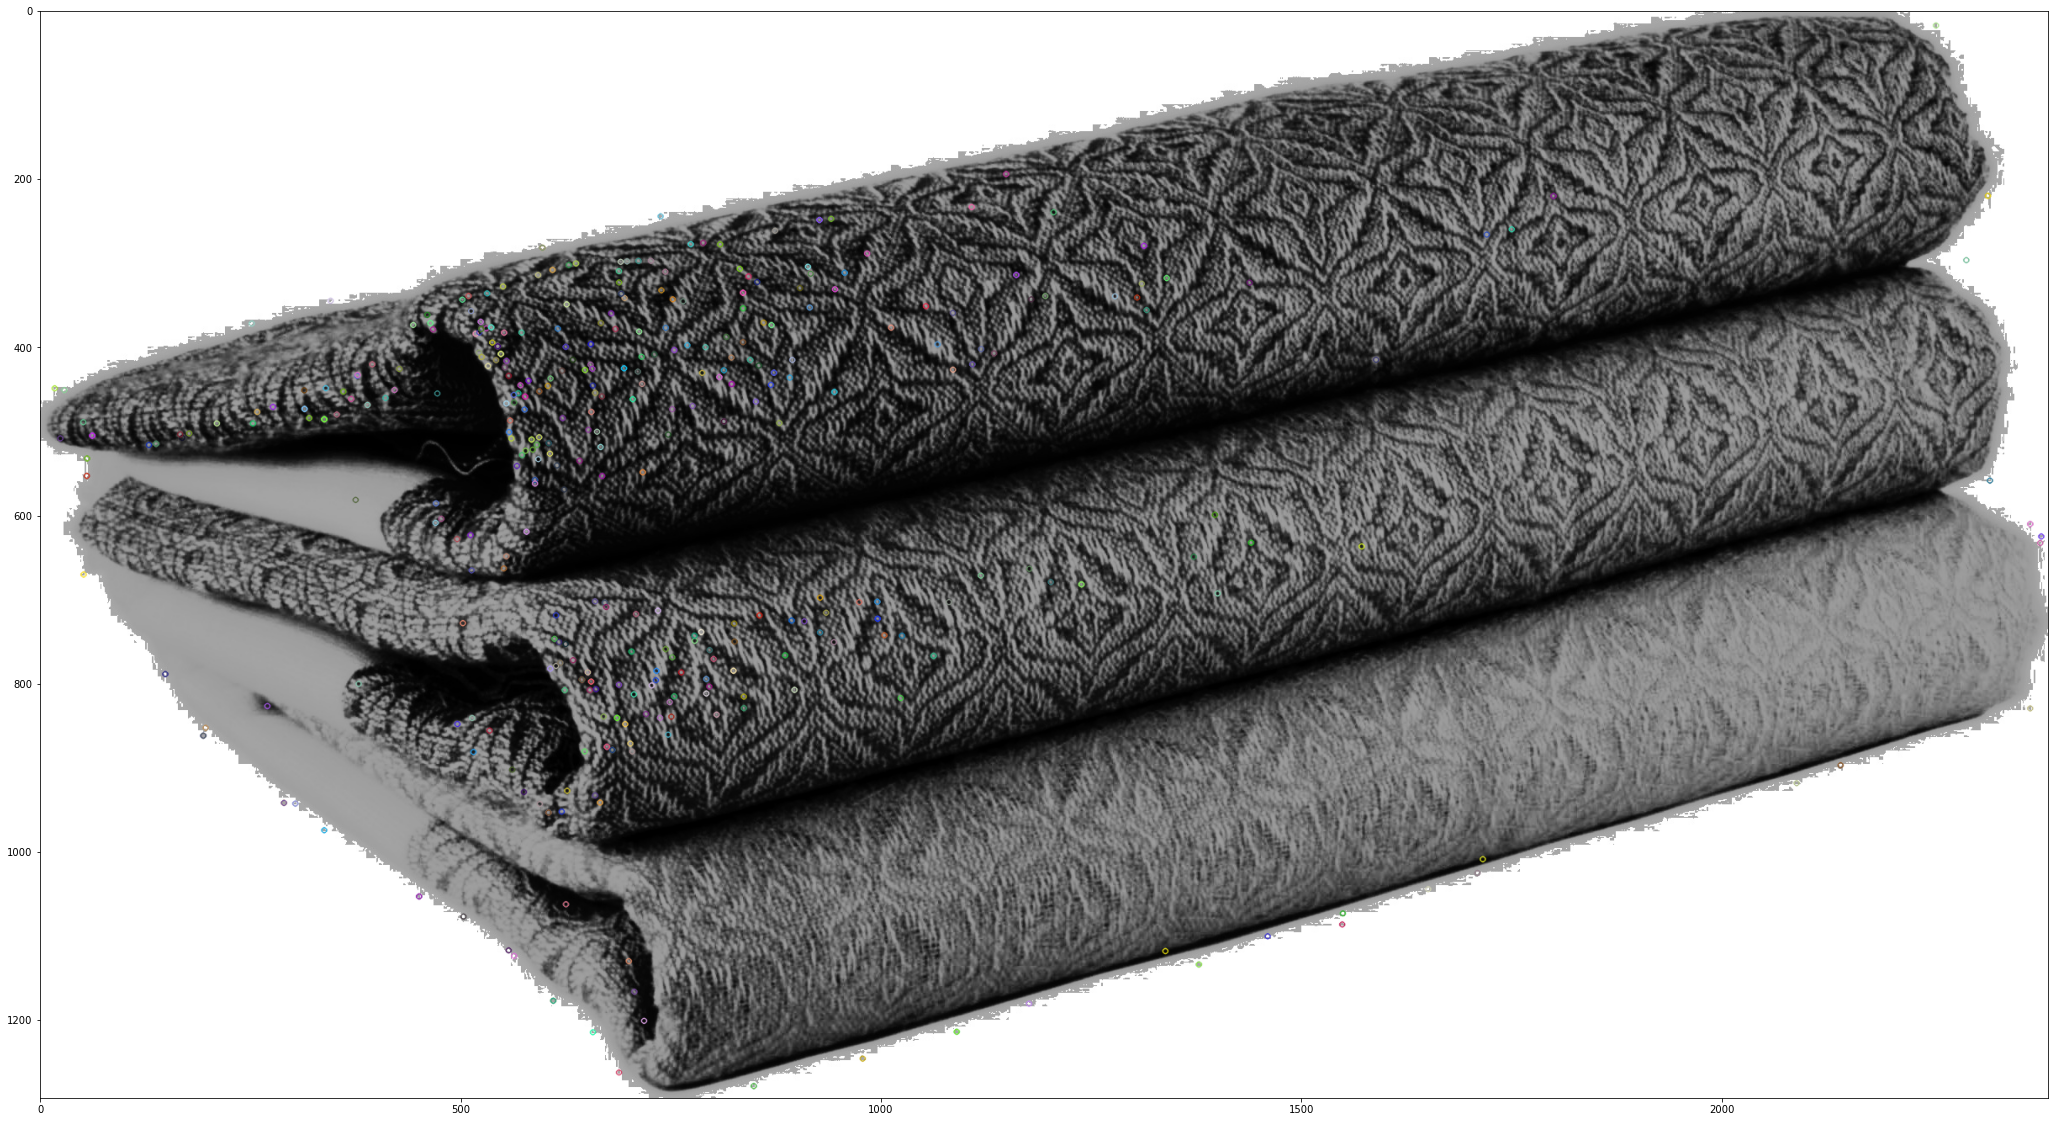

In [17]:
#SIFT_create prend en argument le nombre de features que l'on souhaite avoir
test=imread("1.jpg")
sift = cv2.xfeatures2d.SIFT_create(500) # Ce choix est-il arbitraire ?
kp=sift.detect(test,None)
print("On a",len(kp),"features.")
gray=cv2.drawKeypoints(test,kp,None)
plt.figure(figsize = (50,20))
plt.imshow(gray)

In [18]:
df_image=df_image[["categorie_article","image_propre"]]
df_image

categorie_article image_propre
0      Home Furnishing        0.jpg
1            Baby Care        1.jpg
2            Baby Care        2.jpg
3      Home Furnishing        3.jpg
4      Home Furnishing        4.jpg
...                ...          ...
1045         Baby Care     1045.jpg
1046         Baby Care     1046.jpg
1047         Baby Care     1047.jpg
1048         Baby Care     1048.jpg
1049         Baby Care     1049.jpg

[1050 rows x 2 columns]

In [19]:
df_image.groupby("categorie_article").count()

image_propre
categorie_article                       
Baby Care                            150
Beauty and Personal Care             150
Computers                            150
Home Decor & Festive Needs           150
Home Furnishing                      150
Kitchen & Dining                     150
Watches                              150

In [20]:
path=os.getcwd()
print(path)

/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images


In [21]:
for image_num in range(len(df_image.values)) :
    a=path+str(df_image.loc[image_num,"image_propre"])
    print(a)

/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images0.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images1.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images2.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images3.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images4.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images5.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images6.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images7.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images8.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images9.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images10.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images11.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images12.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images13.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images14.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Images15.jpg
/Users/samueljacquot/Desktop/P6_SAMUEL_JACQUOT/Ima

In [22]:
# identification of key points and associated descriptors

sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(df_image.values)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(df_image.loc[image_num,"image_propre"],0)
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints.append(des)


0
100
200
300
400
500
600
700
800
900
1000


In [23]:
sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)



Nombre de descripteurs :  (517327, 128)
temps de traitement SIFT descriptor :           350.59 secondes


In [24]:

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :            45.00 secondes


In [25]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             2.09 secondes


In [26]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 499)


In [27]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_image["categorie_article"]
print(df_tsne.shape)


(1050, 3)


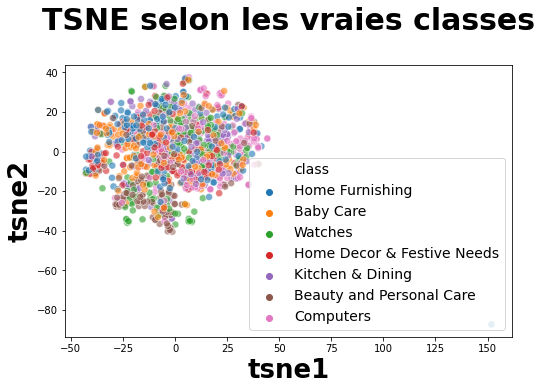

In [28]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


In [29]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


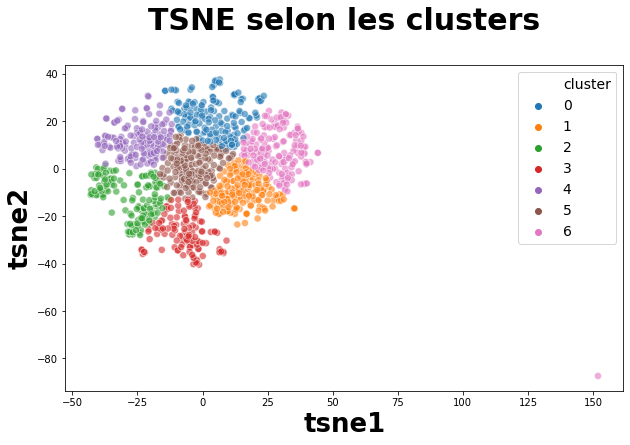

ARI :  0.04964222194799677


In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_image["categorie_article"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Approche CNN

# Partie Texte

Dans cette partie, nous étudierons la faisabilité d'un moteur de classiffication en utilisant uniquement les descriptions des articles de notre échantillon.

### Pré-processing

In [31]:
test=df["description"][1]
test


'Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel'

In [34]:
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# En minuscule
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words]
    return lw

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

def sans_chiffre(toto):
    number=["0","1","2","3","4","5","6","7","8","9"]
    for i in range(10):
        toto=[ x for x in toto if number[i] not in x ]
    return(toto)




test2=sans_chiffre(lemma_fct(lower_start_fct(stop_word_filter_fct(tokenizer_fct(test)))))
test2

['specification',
 'sathiyas',
 'cotton',
 'bath',
 'towel',
 'bath',
 'towel',
 'red',
 'yellow',
 'blue',
 'bath',
 'towel',
 'feature',
 'machine',
 'washable',
 'yes',
 'material',
 'cotton',
 'design',
 'self',
 'design',
 'general',
 'brand',
 'sathiyas',
 'type',
 'bath',
 'towel',
 'gsm',
 'model',
 'name',
 'sathiyas',
 'cotton',
 'bath',
 'towel',
 'ideal',
 'for',
 'men',
 'woman',
 'boy',
 'girl',
 'model',
 'color',
 'red',
 'yellow',
 'blue',
 'size',
 'mediam',
 'dimension',
 'length',
 'inch',
 'width',
 'inch',
 'box',
 'number',
 'content',
 'sale',
 'package',
 'sale',
 'package',
 'bath',
 'towel']

In [35]:
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    sc=sans_chiffre(lem_w)
    transf_desc_text = ' '.join(sc)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

df['sentence_bow'] = df["description"].apply(lambda x : transform_bow_fct(x))
df['sentence_bow_lem'] =df["description"].apply(lambda x : transform_bow_lem_fct(x))
df['sentence_dl'] = df["description"].apply(lambda x : transform_dl_fct(x))

In [36]:
l_cat = list(set(df["categorie_article"]))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]["categorie_article"])) for i in range(len(df))]

catégories :  ['Home Furnishing', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Baby Care', 'Watches', 'Kitchen & Dining']


In [37]:

df['length_bow'] = df['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", df['length_bow'].max())
df['length_dl'] = df['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df['length_dl'].max())


max length bow :  379
max length dl :  632


In [38]:
df

uniq_id            crawl_timestamp  \
0     55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1     7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2     64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3     d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4     6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   
...                                ...                        ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
0     http://www.flipkart.com/elegance-polyester-mul...   
1     http://www.flipkart.com/sathiyas-cotton-bath-t...   
2     http://www.flipkart.com/eurospa-cotton-terry-f...   
3     http://www.flipkart.com/santosh-royal-fashion-...   
4     http://www.flipkart.com/jaipur-print-cotton-fl...   
...                                                 ...   
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
0     ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   
...                                                 ...               ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
0           1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1            600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2              NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3           2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4           2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...            ...               ...                                   ...   
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1

In [39]:
import time
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des articles par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des articles par clusters')
    
    plt.show()
    print("ARI : ", ARI)
    
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])  
ctf_transform = ctf.transform(df[feat])  

### Approche bag of word comptage mot

In [40]:
pd.value_counts(test2)

bath             6
towel            6
cotton           3
sathiyas         3
package          2
sale             2
design           2
blue             2
model            2
inch             2
yellow           2
red              2
specification    1
width            1
girl             1
boy              1
length           1
brand            1
gsm              1
washable         1
material         1
woman            1
machine          1
yes              1
dimension        1
mediam           1
type             1
box              1
content          1
men              1
number           1
for              1
feature          1
color            1
general          1
self             1
ideal            1
size             1
name             1
dtype: int64

In [41]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()

CountVectorizer : 
-----------------
ARI :  0.4172 time :  7.0



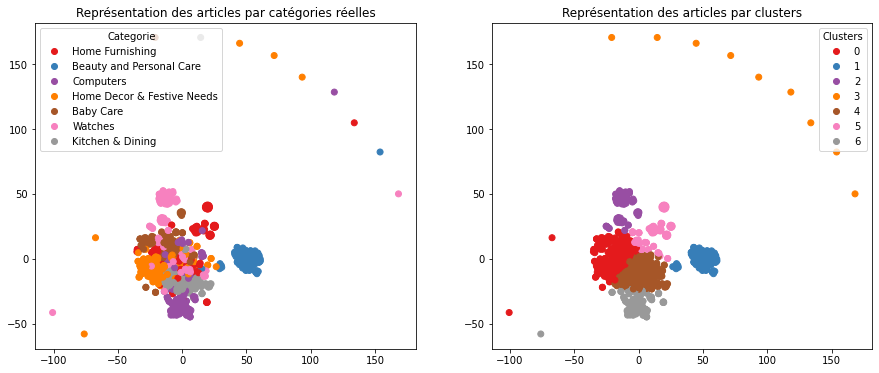

ARI :  0.4172


In [42]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Approche bag of word Tf-idf

In [43]:
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

Tf-idf : 
--------
ARI :  0.4757 time :  6.0


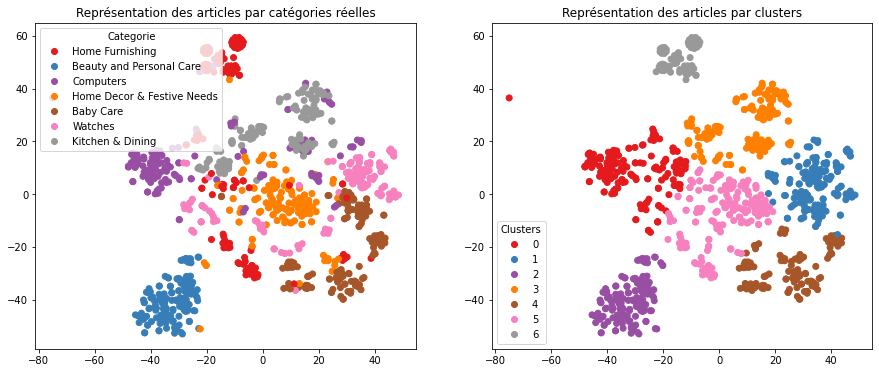

ARI :  0.4757


In [44]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [45]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

### Approche Word2Vec 

In [46]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [47]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4482
Word2Vec trained


In [48]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4483


In [49]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4483, 300)


In [50]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1344900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,344,900
Trainable params: 1,344,900
Non-trainable params: 0
_________________________________________________________________


In [51]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

(1050, 300)

In [52]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.2721 time :  6.0


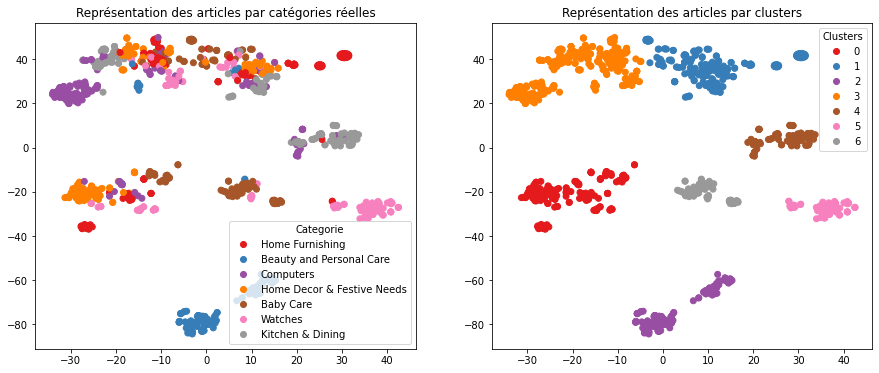

ARI :  0.2721


In [53]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Approche BERT

In [54]:
os.environ["TF_KERAS"]='1'

In [55]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [56]:
from transformers import TFAutoModel
from transformers import AutoTokenizer

max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['sentence_dl'].to_list()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [57]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

temps traitement :  62.0


In [58]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.331 time :  7.0


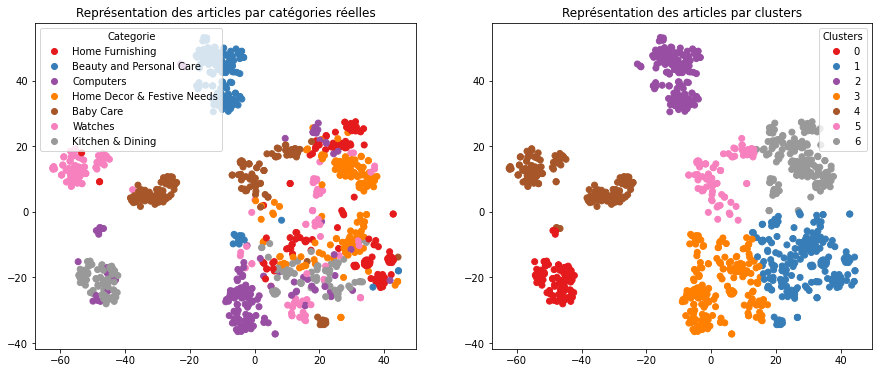

ARI :  0.331


In [59]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Approche USE

In [60]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
#from transformers import *

os.environ["TF_KERAS"]='1'

In [61]:
#pip install CpmTokenizer

In [62]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.8.0
2.8.0
Num GPUs Available:  0
False


In [63]:
import tensorflow_hub as hub

In [64]:
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [65]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [66]:
batch_size = 10
sentences = df['sentence_dl'].to_list()

In [67]:
#features_USE = feature_USE_fct(sentences, batch_size)

In [68]:
#ARI, X_tsne, labels = ARI_fct(features_USE)

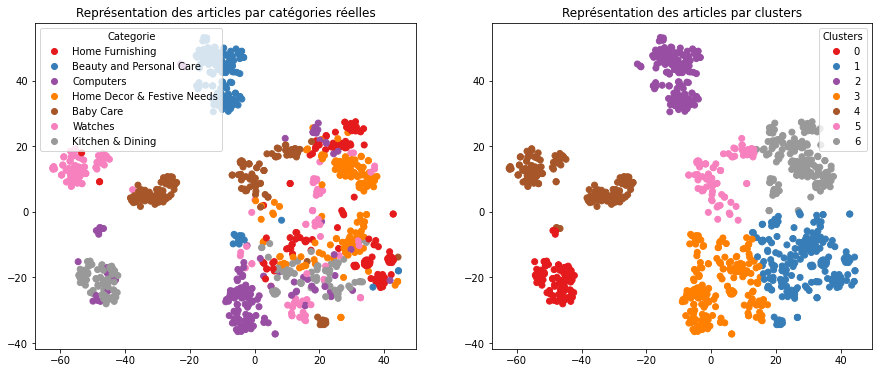

ARI :  0.331


In [69]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Conclusion

Remarque 1 : Les catégories que nous avons utilisés sont très général pour la catégorie 'computer', cela peut autant être un clavier qu'une clé usb. Il faudrait pour l'étape de production augmenter le nombre de catégorie et donc aussi le nombre d'images.